## Modeling and Tuning

This notebook focuses on training, evaluating, and comparing multiple classification models.  
The workflow includes:

1. Loading preprocessed training and test datasets  
2. Training baseline models (Naive Bayes and Random Forest)  
3. Evaluating model performance using Accuracy, F1-score, Confusion Matrix, and ROC-AUC  
4. Hyperparameter tuning using GridSearchCV  
5. Comparing baseline vs tuned models  
6. Final comparison between different model families  

The goal is to select the best-performing model based on both classification metrics and ROC curve analysis.


In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


## Loading the Data

Here we load the preprocessed datasets:
- training dataset
- test dataset
- scaled dataset for future predictions

All datasets were prepared in earlier preprocessing steps.


In [3]:
training_data_wt = pd.read_csv('Nata_Files/processed/train_dataset.csv')
testing_data_wt = pd.read_csv('Nata_Files/processed/test_dataset.csv')
prediction_data = pd.read_csv('Nata_Files/processed/pred_scaled.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Nata_Files/processed/train_dataset.csv'

## Train–Test Feature Separation

In this step, we separate:
- input features (X)
- target variable (y)

This is done for both training and test datasets.


In [4]:
X_train = training_data_wt.drop('target', axis=1)
y_train = training_data_wt['target']
X_test = testing_data_wt.drop('target', axis=1)
y_test = testing_data_wt['target']

## Naive Bayes Classifier — Baseline Model

We start with a Gaussian Naive Bayes classifier as a baseline model.  
This model is simple, fast, and provides a good reference point for more complex models.  

Accuracy: 0.6961538461538461
F1 Score: 0.6932517460751721


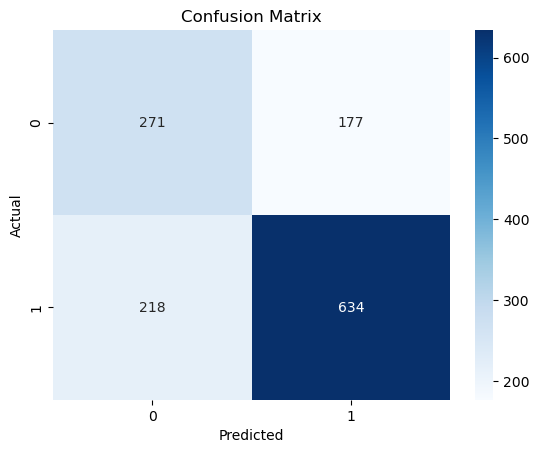

In [5]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predicted = gnb.predict(X_test)
y_pred = gnb.predict(X_test)

# Compute evaluation metrics for baseline Naive Bayes
accuracy = accuracy_score(y_pred, y_test)
f1gnb = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1gnb)

# Visualize classification errors using confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning — Naive Bayes

We use GridSearchCV to find the optimal value of the `var_smoothing`
parameter.  
The weighted F1-score is used as the optimization metric.

In [6]:
# Define search space for variance smoothing parameter
param_grid = {
    "var_smoothing": np.logspace(-12, -6, 50)
}

# Perform cross-validated grid search
grid_search_gnb = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1
)

grid_search_gnb.fit(X_train, y_train)

print("Best estimator:", grid_search_gnb.best_estimator_)
print("Best params:", grid_search_gnb.best_params_)

gnb.score(X_train, y_train), gnb.score(X_test, y_test)

Best estimator: GaussianNB(var_smoothing=np.float64(9.102981779915227e-11))
Best params: {'var_smoothing': np.float64(9.102981779915227e-11)}


(0.6966580976863753, 0.6961538461538461)

## Naive Bayes — Tuned Model

Using the best hyperparameters found during grid search,
we retrain the Naive Bayes model and evaluate its performance
on the test dataset.


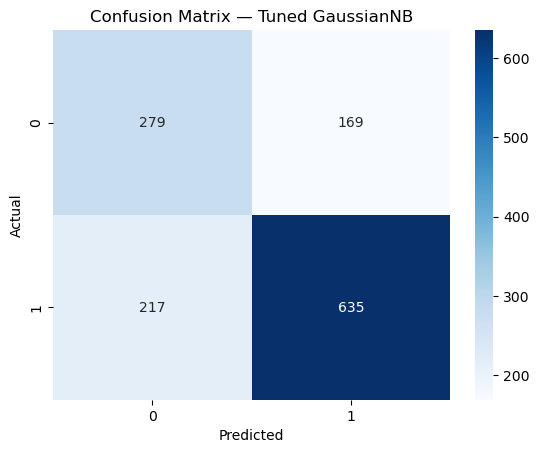

In [7]:
best_var = grid_search_gnb.best_params_['var_smoothing'] # Train Naive Bayes model using optimal hyperparameter

gnb_new = GaussianNB(var_smoothing=best_var)
gnb_new.fit(X_train, y_train)

y_pred_gnb_new = gnb_new.predict(X_test) # Predict with tuned model

accuracy_gnb_new = accuracy_score(y_test, y_pred_gnb_new)
f1_gnb_new = f1_score(y_test, y_pred_gnb_new, average='weighted')

cm = confusion_matrix(y_test, y_pred_gnb_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix — Tuned GaussianNB')
plt.show()


In [8]:
gnb_new.score(X_train, y_train), gnb_new.score(X_test, y_test)

(0.7, 0.703076923076923)

## ROC Curve — Naive Bayes

This section compares the baseline and tuned Naive Bayes models
using ROC curves and AUC scores.


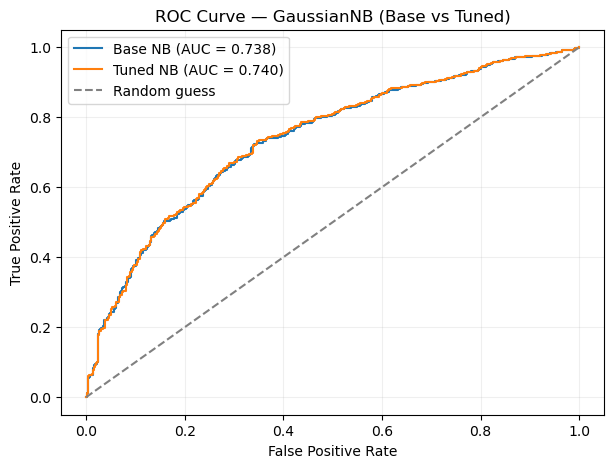

In [9]:
# Convert target labels to binary format for ROC analysis
y_train_bin = y_train.map({'OK': 1, 'KO': 0})
y_test_bin  = y_test.map({'OK': 1, 'KO': 0}) 

# Obtain predicted probabilities for positive class
y_proba_nb_base = gnb.predict_proba(X_test)[:, 1]
y_proba_nb_tuned = gnb_new.predict_proba(X_test)[:, 1]

fpr_nb_base, tpr_nb_base, _ = roc_curve(y_test_bin, y_proba_nb_base)
fpr_nb_tuned, tpr_nb_tuned, _ = roc_curve(y_test_bin, y_proba_nb_tuned)

auc_nb_base = roc_auc_score(y_test_bin, y_proba_nb_base)
auc_nb_tuned = roc_auc_score(y_test_bin, y_proba_nb_tuned)

plt.figure(figsize=(7, 5))
plt.plot(fpr_nb_base, tpr_nb_base, label=f'Base NB (AUC = {auc_nb_base:.3f})')
plt.plot(fpr_nb_tuned, tpr_nb_tuned, label=f'Tuned NB (AUC = {auc_nb_tuned:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — GaussianNB (Base vs Tuned)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


## Random Forest Classifier — Baseline Model

Next, we train a Random Forest classifier.  
This ensemble model is expected to capture more complex non-linear relationships in the data.

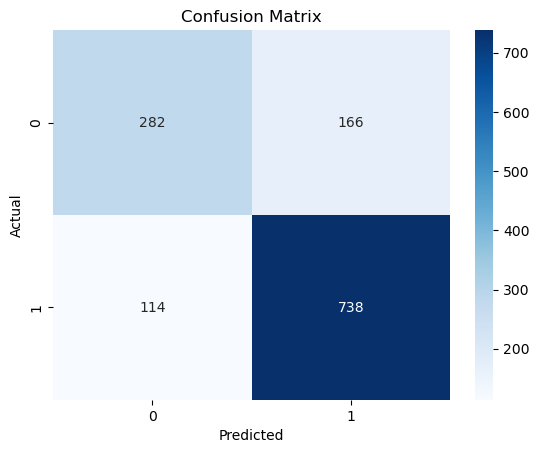

In [10]:
rf = RandomForestClassifier() # Initialize Random Forest with default parameters

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_pred_rf, y_test, average="weighted")

# Evaluate Random Forest predictions using confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(1.0, 0.7846153846153846)

## Hyperparameter Tuning — Random Forest

We perform hyperparameter tuning using GridSearchCV to optimize model complexity and reduce overfitting.


In [12]:
# Define hyperparameter grid for Random Forest optimization
param_grid = {
    'n_estimators': [100, 300, 500, 1000],
    'max_depth': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5],
}

# Initialize GridSearchCV to evaluate all parameter combinations
grid_search  = GridSearchCV(RandomForestClassifier(),
                                   param_grid)
grid_search .fit(X_train, y_train)
print(grid_search .best_estimator_) 

print("Best Parameters:", grid_search .best_params_)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=1000)
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}


## Random Forest — Tuned Model

The Random Forest model is retrained using the optimal hyperparameters obtained from grid search.

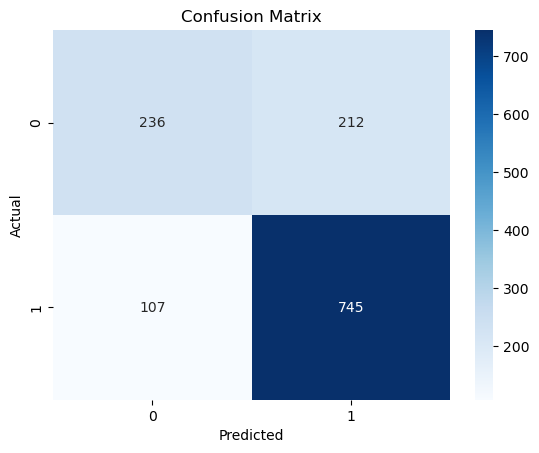

In [13]:
# Retrain Random Forest using selected hyperparameters
rf_new = RandomForestClassifier(
n_estimators=1000,
max_depth=5,
min_samples_split=2,
min_samples_leaf=1,)

rf_new.fit(X_train, y_train)
y_pred_rf_new = rf_new.predict(X_test) # Predict using tuned Random Forest

accuracy_rf_new = accuracy_score(y_test, y_pred_rf_new)
f1_rf_new = f1_score(y_pred_rf_new, y_test, average="weighted")

cm = confusion_matrix(y_test, y_pred_rf_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
rf_new.score(X_train, y_train), rf_new.score(X_test, y_test)

(0.7812339331619538, 0.7546153846153846)

## ROC Curve — Random Forest

This section compares the baseline and tuned Random Forest models using ROC curves and AUC scores.


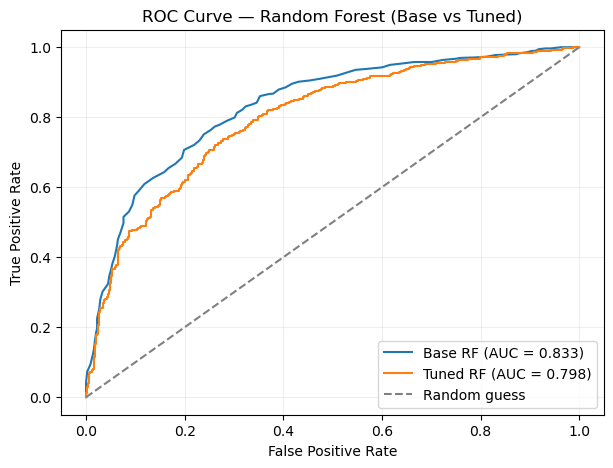

In [15]:
y_train_bin = y_train.map({'OK': 1, 'KO': 0})
y_test_bin  = y_test.map({'OK': 1, 'KO': 0})

y_proba_rf_base = rf.predict_proba(X_test)[:, 1]
y_proba_rf_tuned = rf_new.predict_proba(X_test)[:, 1]

fpr_base, tpr_base, _ = roc_curve(y_test_bin, y_proba_rf_base)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test_bin, y_proba_rf_tuned)

auc_base = roc_auc_score(y_test_bin, y_proba_rf_base)
auc_tuned = roc_auc_score(y_test_bin, y_proba_rf_tuned)

plt.figure(figsize=(7, 5))
plt.plot(fpr_base, tpr_base, label=f'Base RF (AUC = {auc_base:.3f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned RF (AUC = {auc_tuned:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Random Forest (Base vs Tuned)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()


## Final Model Comparison — Random Forest vs Naive Bayes

Finally, we compare the best versions of both models using ROC curves and AUC scores to determine the overall best-performing classifier.

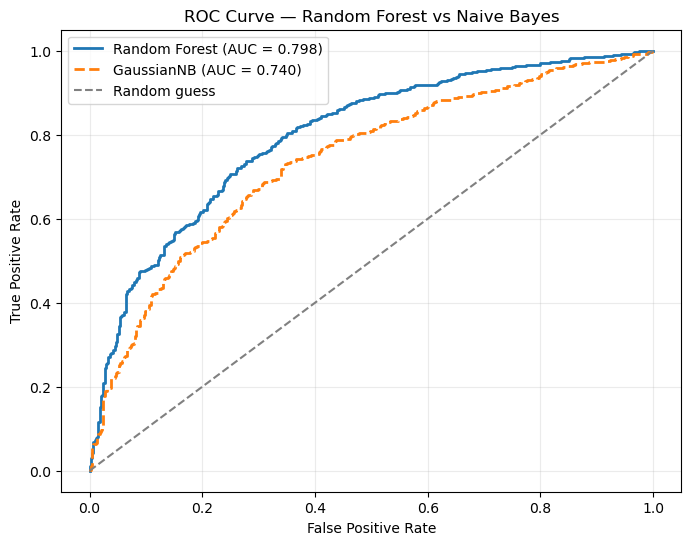

In [16]:
y_test_bin = y_test.map({'OK': 1, 'KO': 0})

# Compare final models using ROC curves and AUC scores
y_proba_rf = rf_new.predict_proba(X_test)[:, 1]
y_proba_nb = gnb_new.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test_bin, y_proba_rf)
fpr_nb, tpr_nb, _ = roc_curve(y_test_bin, y_proba_nb)

auc_rf = roc_auc_score(y_test_bin, y_proba_rf)
auc_nb = roc_auc_score(y_test_bin, y_proba_nb)

plt.figure(figsize=(8, 6))

plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)
plt.plot(fpr_nb, tpr_nb, label=f"GaussianNB (AUC = {auc_nb:.3f})", linewidth=2, linestyle="--")

plt.plot([0, 1], [0, 1], 'k--', color='grey', label="Random guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest vs Naive Bayes")
plt.legend()
plt.grid(alpha=0.25)
plt.show()


## Summary and Conclusions

Based on the evaluation metrics and ROC-AUC analysis,
the Random Forest model demonstrates better overall performance
compared to the Naive Bayes classifier.
